In [1]:
# Import modules

# reload module before executing code
%load_ext autoreload
%autoreload 2

# Load packages
import numpy as np
import pandas as pd
import ast
from odc.stac import stac_load
import time
import psutil
import dask.distributed
import rioxarray
import numpy as np
import xarray as xr
from pystac_client import Client
import matplotlib.pyplot as plt
import pandas as pd 
from sdc_utilities import *
# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")

ds_clean = None
ds_astat = None

In [2]:
# %load "config_cell.txt"
# Configuration

product = 'landsat_ot_c2_l2'
measurements = ['QA_PIXEL', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
aliases = ['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']  # you can also provide only the aliases and get the measurements with:
# measurements, aliases = get_alias_band(aliases)
# to make your live easier you can manually replace the measurements variable by 
# one of their alias:

longitude =  (9.876, 9.964) 
latitude =  (46.3477, 46.4297)
crs = 'epsg:4326'

time = ('2013-09-01', '2024-09-15')
#time = ('2024-04-01', '2024-07-01')
# the following date formats are also valid:
# time = ('2000-01-01', '2001-12-31')
# time=('2000-01', '2001-12')
# time=('2000', '2001')

# You can use an UTM zone according to the DataCube System.
# We prefer not to use this, instead specifying SwissGrid (epsg:2056).
# output_crs = 'epsg:2056'

output_crs = 'epsg:2056'
resolution = -30.0, 30.0

# These are the pixel classifications for Sentinel (SCL) and Landsat (QA_PIXEL); 
# you can use values to mask out values that belong to certain classes

###################################
# SCL categories:                 #
#   0 - no data                   #
#   1 - saturated or defective    #
#   2 - dark area pixels          #
#   3 - cloud_shadows             #
#   4 * vegetation                #
#   5 * not vegetated             #
#   6 * water                     #
#   7 * unclassified              #
#   8 - cloud medium probability  #
#   9 - cloud high probability    #
#  10 - thin cirrus               #
#  11 * snow                      #
###################################

# Check for more detailed information: 
# - Landsat 8/9 (OLI/TIRS), Page 19:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v6.pdf
# - Landsat 7 (ETM+), Page 15:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1337_Landsat7ETM-C2-L2-DFCB-v6.pdf
# - Landsat 4,5 (TM), Page 18:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1415_Landsat4-5-TM-C2-L1-DFCB-v3.pdf

#############################################
# QA_PIXEL BITS : CATEGORIES                #
#    0 : Fill                               #
#    1 : Clear                              #
#    2 : Water                              #
#    3 : Cloud shadow                       #
#    4 : Snow                               #
#    5 : Cloud                              #
#   10 : Terrain occlusion (Landsat 8 only) #
#############################################

chunks = {"x": 2048, "y": 2048, "time": 1}  # 2048 values are OK with ~21Gb memory available

In [3]:
# Work around with dask
client = dask.distributed.Client()
catalog = Client.open("https://explorer.swissdatacube.org/stac")


In [4]:
# Load dataset with parameters defined in the config cell
dataset_in = load_product_ts(catalog=catalog,
                        product=product,
                        longitude=longitude,
                        latitude=latitude,
                        output_crs=output_crs,
                        measurements=measurements,
                        resolution = resolution,
                        time=time,
                        chunks=chunks,
                        rename=True,
                        alias_names = aliases
                        )

## Pre-defined cloud identification and classification

Check the notebook `help_cloudcover.ipynb` for more information.
It makes sense to find out first what pixel classification (clouds, water, land, etc.) works best for your study region. Some classes might not work in mountains and on snow. Then a manual selection (plotting several scenes and identify the dates you want) might be your best choice.

The overview of pixel classifications and quality flags can be found online. The links are provided in the `config_cell.txt` file, and screenshots of these tables in the folder `data/` with the names `Landsat8_QA_PIXEL.png`, `Landsat4-7_QA_PIXEL.png`, and `Sentinel2_SCL.png`.

<img src="https://www.dropbox.com/scl/fi/zslaub479bjrpmqnlrkb3/Landsat8_QA_PIXEL.png?rlkey=jglvektr4mw7vax5bcm97jd1p&dl=1" width="600" />

*Figure 1: Landsat 8 QA_PIXEL Bit flags example.*

In [5]:
# We want to mask out the 'fill' values (no measurement) and 'cloud' 
bit_positions = [0,3]  
ds_tmp = create_mask_from_bits(dataset_in, bit_positions)
ds_tmp = fix_crs(ds_tmp)

In [6]:
# cleaning 

# set all values of identified pixels to not assigned 'np.nan'
ds_na = ds_tmp.where(ds_tmp['mask'] != 1, other=np.nan)

# # to drop all empty timesteps and the QA_PIXEL/SCL layer:
# ds_clean = ds_na_reduced.dropna(dim='time', how='all')

# to keep the QA_PIXEL/SCL layer, you need to select one band that is NOT the quality layer
_band_check = 'blue'
ds_clean = ds_na.dropna(dim='time', how='all', subset=[_band_check])

# there are some issues with the CRS. This one-liner makes sure the CRS is working as intended.
ds_clean = fix_crs(ds_clean)



/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/pohle/miniforge3/envs/pystac_example/lib/py

In [12]:
ds_clean.to_netcdf("ep_ls8_noclouds.nc")

# dataset_in = xr.open_dataset(nc_filename, engine='netcdf4')

/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


### Optional: add normalised difference index

In [13]:
# OPTIONAL CELL TO CALCULATE NDIs
# You can already calculate normalised difference indexes here to be saved with the measurements.
# To do this, use the relevant line(s) below and/or add your own.

ds_clean['ndsi'] = (ds_clean.green - ds_clean.swir_1) / (ds_clean.green + ds_clean.swir_1)
#ds_clean['ndwi'] = (ds_clean.green - ds_clean.nir) / (ds_clean.green + ds_clean.nir)

# 'NDWI': '(ds.green - ds.nir) / (ds.green + ds.nir)',
# 'NDBI': '(ds.swir2 - ds.nir) / (ds.swir2 + ds.nir)'

# As always, fix the CRS:
ds_clean = fix_crs(ds_clean)

### Take a quick look at the summary of the data

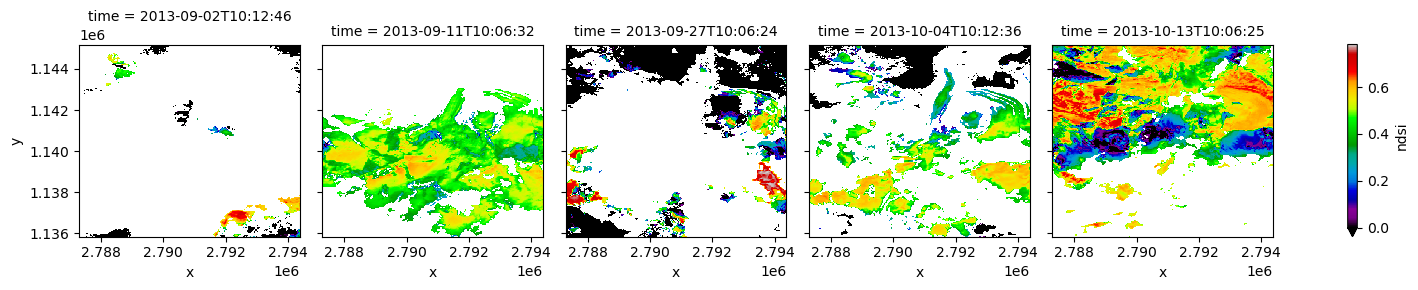

In [14]:
ds_clean.ndsi[0:5,:,:].plot(col='time', vmin=0, cmap='nipy_spectral')

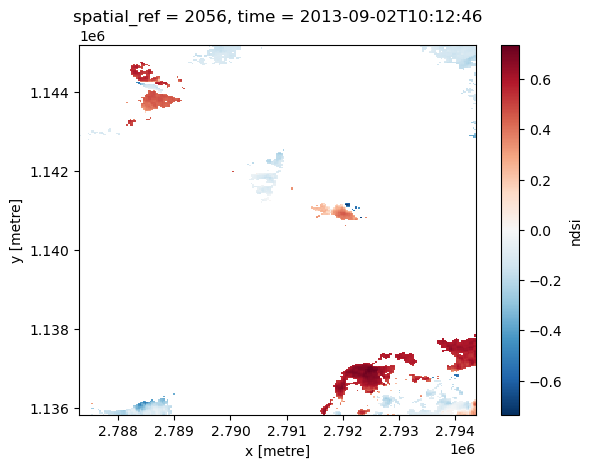

In [15]:
ds_clean.ndsi[0,:,:].plot()

## Add land use statistics

In [16]:
# Here, we manually change the variables `product` and `measurements` to specify what we want to load from arealstatistik.
# We leave longitude, latitude, resolution, output_crs exactly as they were for Landsat. 
# This ensures that the data from arealstatistik will match the spatial coordinates of Landsat perfectly.

# Specify the arealstatistik product
product = ['arealstatistik']

# Here, the measurements are not individual colour bands, 
# but instead are the different surveys with the desired number of classes.
# By default we are loading the surveys for the most recent time period: 2013-2018.
# To see all the available surveys, refer to the arealstatistik PDF document and explore_datacube.ipynb.
measurements = ['AS18_4', 'AS18_17', 'AS18_27', 'AS18_72']

In [17]:
query = catalog.search(
    collections=[product],
    limit=100,
    bbox=(longitude[0], latitude[0],
          longitude[1], latitude[1])
)
items = list(query.items())

# load identified items
ds_astat = stac_load(
    items,
    lon=longitude,
    lat=latitude,
    bands=measurements,
    crs=output_crs,
    resolution=resolution[1],
    chunks=chunks,
)

# Squeeze to remove the defunct time dimension [otherwise we retain a default timestamp of 1970-01-01, which is not helpful].
ds_astat = ds_astat.squeeze()

# and as usual apply the CRS fix:
ds_astat = fix_crs(ds_astat)

### Take a quick look at the summary of these data

## Saving the data

In [18]:
## First, figure out if we need to combine Landsat data with arealstatistik.

if (ds_clean is not None) and (ds_astat is not None):
    # In this case, you have loaded both Landsat and arealstatistik.
    # So, let's combine them into a single Dataset, allowing them to be saved together.
    ds_save = xr.merge([ds_clean, ds_astat])
elif (ds_clean is not None):
    # We are saving only the Landsat dataset
    ds_save = ds_clean
elif (ds_astat is not None):
    # We are saving only the arealstatistik dataset
    ds_save = ds_astat
else:
    raise ValueError('Hmm, unknown combination of data. Ask a teacher for help.')

# you guessed correctly, we make sure to apply the fix (there is not always an issue, but this fix is very fast)
ds_save = fix_crs(ds_save)

### This is what will be saved...

In [19]:
ds_save

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 497, y: 312, x: 236)
Coordinates:
  * y            (y) float64 2kB 1.145e+06 1.145e+06 ... 1.136e+06 1.136e+06
  * x            (x) float64 2kB 2.787e+06 2.787e+06 ... 2.794e+06 2.794e+06
    spatial_ref  int32 4B 2056
  * time         (time) datetime64[ns] 4kB 2013-09-02T10:12:46 ... 2024-07-31...
Data variables: (12/13)
    QA_PIXEL     (time, y, x) float64 293MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    blue         (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    green        (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    red          (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    nir          (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    swir_1       (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    ...           ...
    mask         (time, y, x) float64 293MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    ndsi         (time, y, x) float32 146MB dask.array<chunksize=(1, 312, 236), meta=np.ndarray>
    AS18_4       (y, x) float32 295kB dask.array<chunksize=(312, 236), meta=np.ndarray>
    AS18_17      (y, x) float32 295kB dask.array<chunksize=(312, 236), meta=np.ndarray>
    AS18_27      (y, x) float32 295kB dask.array<chunksize=(312, 236), meta=np.ndarray>
    AS18_72      (y, x) float32 295kB dask.array<chunksize=(312, 236), meta=np.ndarray>

### Save the file.

In [20]:
# Save the file. Change the output filename to something useful!
output_filename = 'ep_ls8_noclouds_witharealstat.nc'
ds_save.to_netcdf(output_filename)


/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/pohle/miniforge3/envs/pystac_example/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
